In [2]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  
# Import necessary metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix,roc_curve,auc,precision_recall_fscore_support
# Import machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
import joblib
import json
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization,Activation
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
import time
from sklearn.metrics import ConfusionMatrixDisplay
from xgboost import plot_importance

In [4]:
df = pd.read_csv(r"C:\Users\hp\Desktop\TFG\Datasets\mergedDS.csv")


In [7]:
# Check attack labels for dur=0 rows
dur_zero_attack_stats = df[df['dur'] == 0]['is_attack'].value_counts(normalize=True)
print("Attack distribution for dur=0 rows:\n", dur_zero_attack_stats)

Attack distribution for dur=0 rows:
 is_attack
0    0.930393
1    0.069607
Name: proportion, dtype: float64


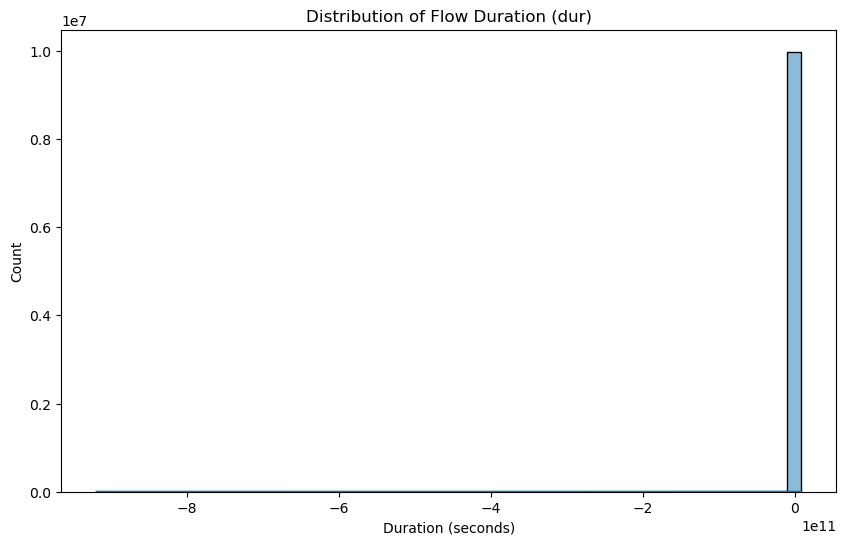

In [6]:
# Drop rows where dur=0 and is_attack=0 AND there is no traffic
df = df[~((df['dur'] == 0) & (df['is_attack'] == 0) & 
          (df['sbytes'] + df['dbytes'] == 0) & (df['Spkts'] + df['Dpkts'] == 0))]

# For attack rows (is_attack=1), set dur=1 microsecond
df.loc[(df['dur'] == 0) & (df['is_attack'] == 1), 'dur'] = 1

# Recalculate flow rates after fixing dur=0
df['Flow Byts/s'] = (df['sbytes'] + df['dbytes']) / (df['dur'] / 1_000_000)
df['Flow Pkts/s'] = (df['Spkts'] + df['Dpkts']) / (df['dur'] / 1_000_000)


In [8]:
df.loc[(df['sbytes'] + df['dbytes'] == 0), 'Flow Byts/s'] = 0  
df.loc[(df['Spkts'] + df['Dpkts'] == 0), 'Flow Pkts/s'] = 0    


In [10]:
# Replace infinite values with a high value
df.replace([np.inf, -np.inf], 1_000_000, inplace=True)

In [19]:
df.isna().sum().sum()

0

In [14]:
negative_values = (df < 0).sum().sum()
print(negative_values)

5524424


In [16]:
# Corrected code to filter negative 'dur' values and 'is_attack' == 1
print("Negative 'dur' in attacks:", df[(df['dur'] < 0) & (df['is_attack'] == 1)].shape[0])


Negative 'dur' in attacks: 0


In [18]:
# Keep only rows where dur >= 0
original_size = len(df)
df = df[df['dur'] >= 0]
print(f"Removed {original_size - len(df)} rows with negative 'dur'")

Removed 105 rows with negative 'dur'


In [20]:
# 1. Split data
X = df.drop('is_attack', axis=1)
y = df['is_attack']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [29]:
# 2. Scale only for Neural Network and Logistic Regression 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
# 3.  FINAL Neural Net builder
from tensorflow.keras.callbacks import EarlyStopping
def create_nn():
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    return model

# 4. Early stopping and wrap NN in sklearn
early_stop = EarlyStopping(monitor='val_loss', patience=3)
weights = {0: 1, 1: 3}
nn_classifier = KerasClassifier(
    build_fn=create_nn,
    epochs=50,
    batch_size=1024,
    verbose=1,
    class_weight=weights,
    callbacks=[early_stop]
)

# Train the model
nn_classifier.fit(X_train_scaled, y_train)
print("\n=== Training Neural Network ===")
start = time.time()
y_pred = nn_classifier.predict(X_test_scaled)
end = time.time()
total_time = end - start
avg_time_per_sample = total_time / X_test_scaled.shape[0]
print(f"Inference time (total): {total_time:.4f} seconds")
print(f"Inference time per sample: {avg_time_per_sample:.6f} seconds")
y_proba = nn_classifier.predict_proba(X_test_scaled)[:, 1]
print(classification_report(y_test, y_pred, target_names=['Benign', 'Attack']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")

C:\Users\hp\anaconda3\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\hp\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
7771/7771 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.9402 - loss: 0.3010 - precision: 0.8682 - recall: 0.8942
Epoch 2/50


C:\Users\hp\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,precision,recall
  current = self.get_monitor_value(logs)


7771/7771 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.9598 - loss: 0.2192 - precision: 0.9168 - recall: 0.9201
Epoch 3/50
7771/7771 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.9628 - loss: 0.2051 - precision: 0.9231 - recall: 0.9259
Epoch 4/50
7771/7771 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.9635 - loss: 0.1992 - precision: 0.9232 - recall: 0.9293
Epoch 5/50
7771/7771 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.9639 - loss: 0.1953 - precision: 0.9234 - recall: 0.9308
Epoch 6/50
7771/7771 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.9646 - loss: 0.1916 - precision: 0.9242 - recall: 0.9325
Epoch 7/50
7771/7771 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.9648 - loss: 0.1894 - precision: 0.9241 - recall: 0.9341
Epoch 8/50
7771/7771 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.9651 - loss: 0.1869 - precision: 0.9244 - recall: 0.9348
Epoch 9/50
7771/7771 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.9657 - loss: 0.1852 - precision: 0.9259 - recall: 0.9353
Epo

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.6min


building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    6.1s finished


Inference time (total): 6.6775 seconds
Inference time per sample: 0.000003 seconds

Classification report using threshold = 0.52:
              precision    recall  f1-score   support

      Benign       0.98      1.00      0.99   1499489
      Attack       0.99      0.93      0.96    489649

    accuracy                           0.98   1989138
   macro avg       0.99      0.97      0.98   1989138
weighted avg       0.98      0.98      0.98   1989138

ROC-AUC: 0.9941


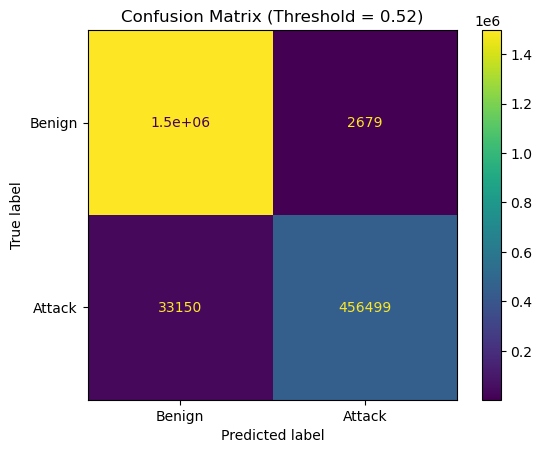

In [37]:
# Final Random Forest model
rf = RandomForestClassifier(
    random_state=42,
    n_estimators=100, 
    min_samples_split=10, 
    min_samples_leaf=2, 
    max_features='log2',
    max_depth=30,
    verbose=2,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Inference timing
start = time.time()
y_proba = rf.predict_proba(X_test)[:, 1]
end = time.time()

# Apply custom threshold of 0.52
y_final_pred = (y_proba >= 0.52).astype(int)

# Evaluation
print(f"Inference time (total): {end - start:.4f} seconds")
print(f"Inference time per sample: {(end - start) / X_test.shape[0]:.6f} seconds")
print("\nClassification report using threshold = 0.52:")
print(classification_report(y_test, y_final_pred, target_names=['Benign', 'Attack']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")

#  Display confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_final_pred, display_labels=['Benign', 'Attack'])
plt.title("Confusion Matrix (Threshold = 0.52)")
plt.grid(False)
plt.show()

In [22]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
import time

# === Final XGBoost Model with Best Parameters ===
final_xgb = XGBClassifier(
    subsample=0.8,
    scale_pos_weight=3,
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    gamma=0.1,
    colsample_bytree=1.0,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    tree_method='hist'
)

# === Train the Model ===
final_xgb.fit(X_train, y_train)

# === Evaluate the Model ===
start_time = time.time()
y_pred = final_xgb.predict(X_test)
y_proba = final_xgb.predict_proba(X_test)[:, 1]
end_time = time.time()

# === Metrics ===
print("=== Final Model Evaluation ===")
print(f"Inference time (total): {end_time - start_time:.4f} seconds")
print(f"Inference time per sample: {(end_time - start_time) / X_test.shape[0]:.6f} seconds")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"Average Precision: {average_precision_score(y_test, y_proba):.4f}")
print(classification_report(y_test, y_pred, target_names=["Benign", "Attack"]))


C:\Users\hp\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:13:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== Final Model Evaluation ===
Inference time (total): 3.3860 seconds
Inference time per sample: 0.000002 seconds
ROC-AUC: 0.9931
Average Precision: 0.9861
              precision    recall  f1-score   support

      Benign       0.98      0.99      0.99   1506137
      Attack       0.96      0.95      0.95    489649

    accuracy                           0.98   1995786
   macro avg       0.97      0.97      0.97   1995786
weighted avg       0.98      0.98      0.98   1995786



In [83]:
# FINAL logistic regression only for binary model
lr = LogisticRegression(max_iter=1000, n_jobs=-1)
print("\n=== Training Logistic Regression ===")
lr.fit(X_train, y_train)
start = time.time()
y_pred = lr.predict(X_test)
end = time.time()
total_time = end - start
avg_time_per_sample = total_time / X_test.shape[0]
print(f"Inference time (total): {total_time:.4f} seconds")
print(f"Inference time per sample: {avg_time_per_sample:.6f} seconds")
y_proba = lr.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred, target_names=['Benign', 'Attack']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Attack'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# === ROC Curve ===
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


=== Training Logistic Regression ===
